### Import Useful packages

In [1]:
import math
import lal
import lalsimulation as lalsim
import numpy as np
import matplotlib.pyplot as plt 
import random as rnd
import nlopt
import copy
import typing as typ
import dataclasses as datacl
import time 

from pycbc.filter import match as simple_match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform.utils import coalign_waveforms

/tmp/ipykernel_5688/1289645436.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


### Chirp_mass and effective spin function

In [2]:
def chirp_mass_function(masses:list)->float:

    return ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))


def eff_spin_function(masses:list, spins:list)->float:

    return (spins[0]*masses[0]+spins[1]*masses[1])/(masses[0]+masses[1])

# Class Definition

In [3]:
class params:
    def __init__(self, masses:tuple, spin1:tuple = (0,0,0) ,spin2:tuple= (0,0,0), r: float = 1e6 * lal.PC_SI,
                  incl:float = 0, phiRef:float = 0, longAscNodes:float=0, ecc:float = 0, meanPerAno:float = 0):
        # Atributo de instancia (Se vincula a la instancia)
        self.m1: float = masses[0]
        self.m2: float = masses[1]
        self.s1x:float = spin1[0]
        self.s1y:float = spin1[1]
        self.s1z:float = spin1[2]
        self.s2x:float = spin2[0]
        self.s2y:float = spin2[1]
        self.s2z:float = spin2[2]
        self.distance:float = r
        self.inclination:float = incl
        self.phiRef:float = phiRef
        self.longAscNodes:float = longAscNodes
        self.eccentricity:float = ecc
        self.meanPerAno : float = meanPerAno


    def chirp_mass(self) -> float:
        return chirp_mass_function([self.m1, self.m2])
    

    def eff_spin(self) -> float:
        return eff_spin_function([self.m1, self.m2], [self.s1z, self.s2z])
    
    
    def cambiar_valor_paso(self, n_param: int, h:float, a:float) -> None:
        param_keys = list(self.__dict__.keys())
        param_values = list(self.__dict__.values())
        atributo = param_keys[n_param]
        
        setattr(self, atributo, param_values[n_param]+a*h)

    def __str__(self) -> str:
        return f"mass1: {self.m1} | mass2: {self.m2} | spin1: {self.s1x, self.s1y, self.s1z}| spin2: {self.s2x, self.s2y, self.s2z}, | distance: {self.distance}, |inclination: {self.inclination}, |phiRef: {self.phiRef}, |longAscNodes: {self.longAscNodes}, |eccentricity: {self.eccentricity}| meanPerAno: {self.meanPerAno}"

### Simulation

In [4]:
def simulationTD_IMRPhenomTPHM(parameters: params, delta_T:float, f_min:float, f_ref:float)->tuple:

    Approximant = "IMRPhenomTPHM"

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(waveform_params, mode_array)


    with lal.no_swig_redirect_standard_output_error():
    # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(**parameters.__dict__,
        deltaT=delta_T, f_min=f_min, f_ref=f_ref, params=waveform_params, approximant=lalsim.GetApproximantFromString(Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data 
    time = np.arange(len(h_plus)) * delta_T

    return h_plus, h_cross, time # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example

### Match

In [5]:
def perform_match(hnr, hap, f_lower, f_high, optimized = False, return_phase = False)->tuple:
    FD = isinstance(hnr, FrequencySeries)
    if not FD: 
        hnr, hap = hnr.real(), hap.real()
    
    # Match signal sizes
    length = min(len(hnr), len(hap))
    hnr.resize(length); hap.resize(length)

    # Compute PSD
    if FD: 
        delta_f = hnr.delta_f
    else:
        delta_f = 1/hnr.duration
    
    psd = aLIGOZeroDetHighPower(length, delta_f, f_lower)
    
    # Compute Match
    match_kwargs = dict(vec1 = hnr, vec2 = hap, psd = psd, low_frequency_cutoff = f_lower, high_frequency_cutoff = f_high, return_phase = return_phase)
    return optimized_match(**match_kwargs) if optimized else simple_match(**match_kwargs, subsample_interpolation = True)

### Define and Simulate the target gravitational Wave

In [6]:
mass1_target = 20 * lal.MSUN_SI
mass2_target = 80 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0,0,0.8)
spin2_target = (0,0,0.9)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

# Definition of functions to calculate the masses and spins

We define a few functions to obtain the masses and spins of the system given some other parameters. Using these different functions we can compare the time and accuracy of every idea. For the moment we will compare these ideas:

- Masses and spins
- Chirp Mass + Total mass and spins
- Chirp Mass + Ratio of masses and spins
- Masses and effective spin + spin of 1 BH
- Chirp Mass + Ratio of masses and effective spin + spin of 1 BH

There are other ideas such as, reduced mass, symmetric mass ratio.

We define these parameters as:

$$
M_c=\frac{(m_1m_2)^{3/5}}{(m_1+m_2)^{1/5}}, \quad M_{total}=m_1+m_2, \quad q_m=\frac{m_1}{m_2}.
$$

$$
\chi_{eff}=\frac{\vec{a}_1m_1+\vec{a}_2m_2}{m_1+m_2}\cdot\vec{L}=\frac{a_1m_1+a_2m_2}{m_1+m_2},
$$

where we have used the fact that we will restrict ourselves to a non-precessing case for the moment.

In [6]:
def M_c_and_M_total(total_mass, chirp_mass)->tuple:

    mass1 = (total_mass+math.sqrt(total_mass**2-4*(total_mass*chirp_mass**5)**(1/3)))/2
    mass2 = (total_mass-math.sqrt(total_mass**2-4*(total_mass*chirp_mass**5)**(1/3)))/2
    
    return (mass1, mass2)

def M_c_and_q_m(mass_ratio, chirp_mass)->tuple:

    mass2 = chirp_mass*((1+mass_ratio)/mass_ratio**3)**(1/5)
    mass1 = mass_ratio*mass2
    
    return (mass1, mass2)


def Eff_spin_and_spin1(mass1, mass2, spin1, eff_spin):
    
    spin2 = (eff_spin*(mass1+mass2)-spin1*mass1)/mass2

    return spin1, spin2

# We define each function to optimize

For the moment we restrict ourselves to the non-derivative methods of optimization and non-precessing spins

In [8]:
def opt_match_basic(prms:list, grad): # prms = [m1, m2, a1, a2]

    if (abs(prms[2])-1)>0 or (abs(prms[3])-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin 
    
    if (prms[0]/prms[1])>200 or (prms[1]/prms[0])>200:
        return 0

    parameters = params((prms[0], prms[1]), (0, 0, prms[2]), (0, 0, prms[3]))

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza


def opt_match_chirp_and_total(prms:list, grad): # masses = [M_total, M_c, a1, a2]

    if (prms[0]**2-4*(prms[0]*prms[1]**5)**(1/3))<0:
        return 0 # Penalizacion si la raiz es negativa (es una solución no válida)

    if (abs(prms[2])-1)>0 or (abs(prms[3])-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin

    masses = M_c_and_M_total(prms[0], prms[1])

    if (masses[0]/masses[1])>200 or (masses[1]/masses[0])>200:
        return 0

    parameters = params(masses, (0, 0, prms[2]), (0, 0, prms[3]))
    
    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza


def opt_match_chirp_and_ratio(prms:list, grad): # masses = [q_m, M_c, a1, a2]


    if (abs(prms[2])-1)>0 or (abs(prms[3])-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin

    masses = M_c_and_q_m(prms[0], prms[1])
    parameters = params(masses, (0, 0, prms[2]), (0, 0, prms[3]))
    
    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza


def opt_match_eff_spin_and_spin1(prms:list, grad): # masses = [m1, m2, a_1, eff_spin]

    if (prms[0]/prms[1])>200 or (prms[1]/prms[0])>200:
        return 0

    spins = Eff_spin_and_spin1(prms[0], prms[1], prms[2], prms[3])

    if (abs(spins[0])-1)>0 or (abs(spins[1])-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin
    
    parameters = params((prms[0],prms[1]), (0, 0, spins[0]), (0, 0, spins[1]))

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza


def opt_match_full_2(prms:list, grad): # masses = [q_m, M_c, a_1, eff_spin]

    masses = M_c_and_q_m(prms[0], prms[1])

    if (masses[0]/masses[1])>200 or (masses[1]/masses[0])>200:
        return 0

    spins = Eff_spin_and_spin1(masses[0], masses[1], prms[2], prms[3])

    if (abs(spins[0])-1)>0 or (abs(spins[1])-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin
    
    parameters = params(masses, (0, 0, spins[0]), (0, 0, spins[1]))

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza


def opt_match_full_3(prms:list, grad): # masses = [M_total, M_c, q_a, eff_spin]

    if (prms[0]**2-4*(prms[0]*prms[1]**5)**(1/3))<0:
        return 0 # Penalizacion si la raiz es negativa (es una solución no válida)

    masses = M_c_and_M_total(prms[0], prms[1])

    if (masses[0]/masses[1])>200 or (masses[1]/masses[0])>200:
        return 0

    spins = Eff_spin_and_spin1(masses[0], masses[1], prms[2], prms[3])

    if (abs(spins[0])-1)>0 or (abs(spins[1])-1)>0:
        return 0 # Penalizacion si se saltan la restriccion del spin
    
    parameters = params(masses, (0, 0, spins[0]), (0, 0, spins[1]))

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

### Comenzamos con la optimizacion

In [9]:
mass1_template = 60*lal.MSUN_SI
mass2_template = 20*lal.MSUN_SI
spin1_template = 0.5
spin2_template = 0.5

prms_initial_1=[mass1_template, mass2_template, spin1_template, spin2_template]
prms_initial_2=[(mass1_template + mass2_template), chirp_mass_function([mass1_template, mass2_template]), spin1_template, spin2_template]
prms_initial_3=[(mass1_template/mass2_template), chirp_mass_function([mass1_template, mass2_template]), spin1_template, spin2_template]
prms_initial_6=[mass1_template, mass2_template,
                  spin1_template, eff_spin_function([mass1_template, mass2_template],[spin1_template, spin2_template])]
prms_initial_7=[(mass1_template/mass2_template), chirp_mass_function([mass1_template, mass2_template]),
                  spin1_template, eff_spin_function([mass1_template, mass2_template],[spin1_template, spin2_template])]
prms_initial_8=[(mass1_template+mass2_template), chirp_mass_function([mass1_template, mass2_template]),
                  spin1_template, eff_spin_function([mass1_template, mass2_template],[spin1_template, spin2_template])]

In [10]:
opt1 = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va

opt1.set_lower_bounds([0, 0, -1, -1]) 
opt1.set_upper_bounds([float('inf'), float('inf'), 1, 1]) 

opt1.set_min_objective(opt_match_basic)
# opt1.set_xtol_rel(1e-4)
opt1.set_stopval(-1+1e-4)
prms_final = opt1.optimize(prms_initial_1)
max_match = -opt1.last_optimum_value()


print(f"Optimum at masses {prms_final[0]/lal.MSUN_SI} and {prms_final[1]/lal.MSUN_SI} solar masses and spins {prms_final[2]} and {prms_final[3]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {chirp_mass_function([prms_final[0],prms_final[1]])}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {eff_spin_function([prms_final[0],prms_final[1]], [prms_final[2], prms_final[3]])}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt1.last_optimize_result()}")

Optimum at masses 70.55451683011664 and 22.080351144996257 solar masses and spins 0.9737157386755338 and 0.503858055840447
The target: 20.0 and 80.0 solar masses and spins (0, 0, 0.8) and (0, 0, 0.9)
maximum value = 0.993617285897906
chirp mass: 6.617127330517464e+31, chirp mass target: 6.621828061916796e+31
effective spin parameter: 0.8617209482478061, eff_spin_target: 0.88
result code = 4


In [11]:
opt2 = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt2.set_lower_bounds([0, 0, -1, -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt2.set_upper_bounds([float('inf'), float('inf'), 1, 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt2.set_min_objective(opt_match_chirp_and_total)
#opt2.set_xtol_rel(1e-4)
opt2.set_stopval(-1+1e-4)
prms_final = opt2.optimize(prms_initial_2)
masses_final = M_c_and_M_total(prms_final[0], prms_final[1])
max_match = -opt2.last_optimum_value()


print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {prms_final[2]} and {prms_final[3]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {prms_final[1]}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {eff_spin_function([prms_final[0],prms_final[1]], [prms_final[2], prms_final[3]])}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt2.last_optimize_result()}")

Optimum at masses 81.06384805612511 and 19.737153092785114 solar masses and spins 0.9173023399729304 and 0.636516845236341
The target: 20.0 and 80.0 solar masses and spins (0, 0, 0.8) and (0, 0, 0.9)
maximum value = 0.9999098204083778
chirp mass: 6.611195143674128e+31, chirp mass target: 6.621828061916796e+31
effective spin parameter: 0.8476584478371156, eff_spin_target: 0.88
result code = 2


In [12]:
opt3 = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt3.set_lower_bounds([0, 0, -float('inf'), -float('inf')]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt3.set_upper_bounds([200, float('inf'), float('inf'), float('inf')]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt3.set_min_objective(opt_match_chirp_and_ratio)
#opt3.set_xtol_rel(1e-4)
opt3.set_stopval(-1+1e-4)

prms_final = opt3.optimize(prms_initial_3)
masses_final = M_c_and_q_m(prms_final[0], prms_final[1])
max_match = -opt3.last_optimum_value()


print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {prms_final[2]} and {prms_final[3]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {prms_final[1]}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {eff_spin_function([prms_final[0],prms_final[1]], [prms_final[2], prms_final[3]])}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt3.last_optimize_result()}")

Optimum at masses 84.43092840344673 and 18.992614609081226 solar masses and spins 0.9468609517496231 and 0.2779226196110317
The target: 20.0 and 80.0 solar masses and spins (0, 0, 0.8) and (0, 0, 0.9)
maximum value = 0.9992201496573061
chirp mass: 6.586183406762431e+31, chirp mass target: 6.621828061916796e+31
effective spin parameter: 0.2779226196110317, eff_spin_target: 0.88
result code = 4


In [13]:
opt6 = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt6.set_lower_bounds([lal.MSUN_SI, lal.MSUN_SI, -float('inf'), -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt6.set_upper_bounds([float('inf'), float('inf'), float('inf'), 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt6.set_min_objective(opt_match_eff_spin_and_spin1)
#opt6.set_xtol_rel(1e-4)
opt6.set_stopval(-1+1e-4)

prms_final = opt6.optimize(prms_initial_6)
spins_final = Eff_spin_and_spin1(prms_final[0], prms_final[1], prms_final[2], prms_final[3])
max_match = -opt6.last_optimum_value()


print(f"Optimum at masses {prms_final[0]/lal.MSUN_SI} and {prms_final[1]/lal.MSUN_SI} solar masses and spins {spins_final[0]} and {spins_final[1]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {chirp_mass_function([prms_final[0], prms_final[1]])}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {prms_final[3]}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt6.last_optimize_result()}")

Optimum at masses 81.3391887472855 and 19.69063719258365 solar masses and spins 0.9148486351237344 and 0.6542853339557844
The target: 20.0 and 80.0 solar masses and spins (0, 0, 0.8) and (0, 0, 0.9)
maximum value = 0.9999328666034955
chirp mass: 6.612287883544029e+31, chirp mass target: 6.621828061916796e+31
effective spin parameter: 0.8640650434341508, eff_spin_target: 0.88
result code = 2


In [14]:
opt7 = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt7.set_lower_bounds([0, lal.MSUN_SI, -float('inf'), -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt7.set_upper_bounds([200, float('inf'), float('inf'), 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt7.set_min_objective(opt_match_full_2)
#opt7.set_xtol_rel(1e-4)
opt7.set_stopval(-1+1e-4)

prms_final = opt7.optimize(prms_initial_7)
masses_final = M_c_and_q_m(prms_final[0], prms_final[1])
spins_final = Eff_spin_and_spin1(masses_final[0], masses_final[1], prms_final[2], prms_final[3])
max_match = -opt7.last_optimum_value()


print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {spins_final[0]} and {spins_final[1]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {prms_final[1]}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {prms_final[3]}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt7.last_optimize_result()}")

Optimum at masses 75.09703513684357 and 21.066682391820347 solar masses and spins 0.8710609838837162 and 0.9993446345400889
The target: 20.0 and 80.0 solar masses and spins (0, 0, 0.8) and (0, 0, 0.9)
maximum value = 0.9979202675877341
chirp mass: 6.6288016631039695e+31, chirp mass target: 6.621828061916796e+31
effective spin parameter: 0.899164212355884, eff_spin_target: 0.88
result code = 4


In [15]:
opt8 = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt8.set_lower_bounds([0, lal.MSUN_SI, -float('inf'), -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt8.set_upper_bounds([float('inf'), float('inf'), float('inf'), 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt8.set_min_objective(opt_match_full_3)
#opt8.set_xtol_rel(1e-4)
opt8.set_stopval(-1+1e-4)

prms_final = opt8.optimize(prms_initial_8)
masses_final = M_c_and_M_total(prms_final[0], prms_final[1])
spins_final = Eff_spin_and_spin1(masses_final[0], masses_final[1], prms_final[2], prms_final[3])
max_match = -opt8.last_optimum_value()


print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {spins_final[0]} and {spins_final[1]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {prms_final[1]}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {prms_final[3]}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt8.last_optimize_result()}")

Optimum at masses 72.47111091768815 and 16.774350334814347 solar masses and spins 0.8720080339935473 and -0.9962036024817508
The target: 20.0 and 80.0 solar masses and spins (0, 0, 0.8) and (0, 0, 0.9)
maximum value = 0.8773952153272738
chirp mass: 5.7448019263240955e+31, chirp mass target: 6.621828061916796e+31
effective spin parameter: 0.5208637175207056, eff_spin_target: 0.88
result code = 4


## Vamos a utilizar la última para hacer pruebas
(q_m, chirp_mass, a_1, eff_spin)

In [7]:
mass1_target = 5 * lal.MSUN_SI
mass2_target = 100 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0,0,-0.95)
spin2_target = (0,0,0.2)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [8]:
def Measure(New_Data:list)->list:
    Full_Data.append(New_Data)
    return Full_Data


def opt_match_tests(prms:list, grad): # masses = [q_m, M_c, a_1, eff_spin]

    if prms[0]==0:
        Full_Data = Measure([0, prms[0], prms[1], prms[2], prms[3]])
        return 0

    masses = M_c_and_q_m(prms[0], prms[1])

    if (masses[0]/masses[1])>200 or (masses[1]/masses[0])>200:
        Full_Data = Measure([0, prms[0], prms[1], prms[2], prms[3]])
        return 0

    spins = Eff_spin_and_spin1(masses[0], masses[1], prms[2], prms[3])

    if (abs(spins[0])-1)>0 or (abs(spins[1])-1)>0:
        Full_Data = Measure([0, prms[0], prms[1], prms[2], prms[3]])
        return 0 # Penalizacion si se saltan la restriccion del spin
    
    parameters = params(masses, (0, 0, spins[0]), (0, 0, spins[1]))

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)


    Full_Data = Measure([match, prms[0], prms[1], prms[2], prms[3]])
    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

In [9]:
mass1_template = 20*lal.MSUN_SI
mass2_template = 60*lal.MSUN_SI
spin1_template = 0.0
spin2_template = 0.0

prms_initial_test=[(mass1_template/mass2_template), chirp_mass_function([mass1_template, mass2_template]),
                  spin1_template, eff_spin_function([mass1_template, mass2_template],[spin1_template, spin2_template])]

prms_mass_initial=[(mass1_template/mass2_template), chirp_mass_function([mass1_template, mass2_template])]

In [19]:
Full_Data=[]

opt_test = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt_test.set_lower_bounds([0, lal.MSUN_SI, -float('inf'), -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt_test.set_upper_bounds([float('inf'), float('inf'), float('inf'), 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt_test.set_min_objective(opt_match_tests)
#opt_test.set_xtol_rel(1e-4)
opt_test.set_stopval(-1+1e-4)

prms_final = opt_test.optimize(prms_initial_test)
masses_final = M_c_and_q_m(prms_final[0], prms_final[1])
spins_final = Eff_spin_and_spin1(masses_final[0], masses_final[1], prms_final[2], prms_final[3])
max_match = -opt_test.last_optimum_value()


print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {spins_final[0]} and {spins_final[1]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {prms_final[1]}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {prms_final[3]}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt_test.last_optimize_result()}")


Optimum at masses 22.868433090209933 and 127.92953118386247 solar masses and spins -0.20492846968606962 and -0.17734313567472137
The target: 5.0 and 100.0 solar masses and spins (0, 0, -0.95) and (0, 0, 0.2)
maximum value = 0.40589626124094047
chirp mass: 8.760948848728368e+31, chirp mass target: 3.2632477943965066e+31
effective spin parameter: -0.18152643727395967, eff_spin_target: 0.14523809523809525
result code = 4


### Alternative (Global+NELDERMEAD)

Starting Global Optimization
The match of the global optimization is: 0.4247074561912639. It took 7.15909743309021 seconds.
[ 3.32553651e-01  9.07203282e+31  9.15208566e-01 -3.83821718e-01]
Starting Local Optimization
The match of the total optimization is: 0.5188780714524337.
Optimum at masses 15.882020407913794 and 127.37888488820754 solar masses and spins 0.9998862085743894 and -0.9999694105881757
The target: 5.0 and 100.0 solar masses and spins (0, 0, -0.95) and (0, 0, 0.2)
chirp mass: 35.67601823018451, chirp mass target: 16.411343770139865
effective spin parameter: -0.7782637911048339, eff_spin_target: 0.14523809523809525
result code = 4


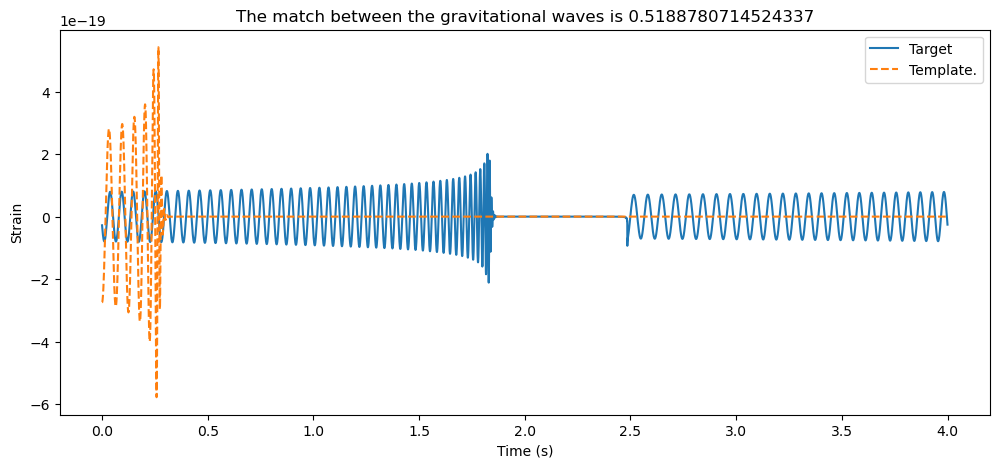

In [20]:
print("Starting Global Optimization")
time_initial=time.time()
Full_Data=[]

opt_test = nlopt.opt(nlopt.GN_MLSL, 4) # De los que he probado AUGLAG es el que mejor va
opt_test.set_lower_bounds([0, lal.MSUN_SI, -1, -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt_test.set_upper_bounds([50, 175*lal.MSUN_SI, 1, 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt_test.set_min_objective(opt_match_tests)
opt_test.set_maxeval(150)

prms_global_final = opt_test.optimize(prms_initial_test)
max_match = -opt_test.last_optimum_value()
print(f"The match of the global optimization is: {max_match}. It took {time.time()-time_initial} seconds.")
print(prms_global_final)
print(f"Starting Local Optimization")

opt_test2 = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt_test2.set_lower_bounds([0, lal.MSUN_SI, -1, -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt_test2.set_upper_bounds([50, 175*lal.MSUN_SI, 1, 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt_test2.set_min_objective(opt_match_tests)
#opt_test2.set_ftol_rel(-1+1e-4)
opt_test2.set_xtol_rel(1e-4)

prms_final = opt_test2.optimize(prms_global_final)
masses_final = M_c_and_q_m(prms_final[0], prms_final[1])
spins_final = Eff_spin_and_spin1(masses_final[0], masses_final[1], prms_final[2], prms_final[3])

max_match = -opt_test2.last_optimum_value()

print(f"The match of the total optimization is: {max_match}.")

print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {spins_final[0]} and {spins_final[1]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"chirp mass: {prms_final[1]/lal.MSUN_SI}, chirp mass target: {parameters_target.chirp_mass()/lal.MSUN_SI}")
print(f"effective spin parameter: {prms_final[3]}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt_test2.last_optimize_result()}")

# Waveforms Coaligned 
hp_test, hc_test, time_test=simulationTD_IMRPhenomTPHM(params(masses_final, (0,0,spins_final[0]), (0,0,spins_final[1])), delta_T, f_min, f_ref)
h1_aligned, h2_aligned = coalign_waveforms(hp_target, TimeSeries(hp_test, delta_t=delta_T))

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Template.', linestyle='dashed')
plt.title(f'The match between the gravitational waves is {max_match}')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

### Otra opcion, ahora primero las masas y luego el resto

In [27]:
def opt_match_mass(prms:list, grad): # masses = [q_m, M_c, a_1, eff_spin]

    if prms[0]==0:
        return 0

    masses = M_c_and_q_m(prms[0], prms[1])

    if (masses[0]/masses[1])>200 or (masses[1]/masses[0])>200:
        return 0
    
    parameters = params(masses)

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

Starting Mass Optimization
The match of the optimization of the masses is: 0.5636735030708809. It took 0.8062193393707275 seconds.
[1.54010928e+01 9.47656578e+31]
[248.96611593  16.16548376]
Starting Total Optimization
The match of the total optimization is: 0.5289872569143791.
Optimum at masses 269.76925006115647 and 16.101548301995567 solar masses and spins 0.5061201765541421 and 0.9974906689862454
The target: 25.0 and 80.0 solar masses and spins (0, 0, 0.95) and (0, 0, 0.95)
chirp mass: 49.14531141599453, chirp mass target: 37.703367184101
effective spin parameter: 0.533796405687627, eff_spin_target: 0.95
result code = 4


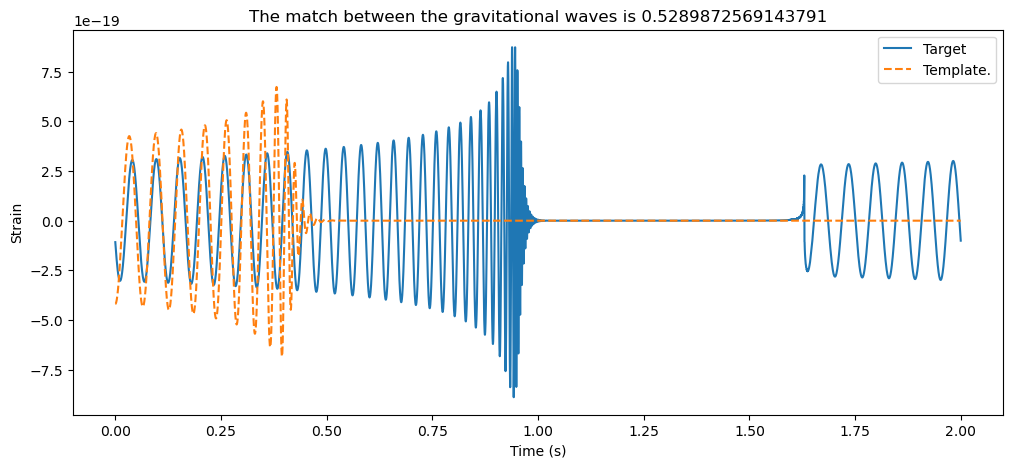

In [46]:
print("Starting Mass Optimization")
time_initial=time.time()
Full_Data=[]

opt_mass = nlopt.opt(nlopt.GN_MLSL, 2) # De los que he probado AUGLAG es el que mejor va
opt_mass.set_lower_bounds([0, lal.MSUN_SI]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt_mass.set_upper_bounds([20, 175*lal.MSUN_SI]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt_mass.set_min_objective(opt_match_mass)
#opt_mass.set_xtol_rel(1e-2)
opt_mass.set_maxeval(100)

prms_mass_final = opt_mass.optimize(prms_mass_initial)
max_match = -opt_mass.last_optimum_value()
print(f"The match of the optimization of the masses is: {max_match}. It took {time.time()-time_initial} seconds.")
print(prms_mass_final)
print(np.array(M_c_and_q_m(*prms_mass_final))/lal.MSUN_SI)
print(f"Starting Total Optimization")

opt_total = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt_total.set_lower_bounds([0, lal.MSUN_SI, -1, -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt_total.set_upper_bounds([20, 175*lal.MSUN_SI, 1, 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt_total.set_min_objective(opt_match_tests)
#opt_total.set_ftol_rel(-1+1e-4)
opt_total.set_xtol_rel(1e-4)

prms_total_initial=[prms_mass_final[0],prms_mass_final[1],spin1_template,eff_spin_function(list(M_c_and_q_m(*prms_mass_final)),[spin1_template,spin2_template])]
prms_final = opt_total.optimize(prms_total_initial)
masses_final = M_c_and_q_m(prms_final[0], prms_final[1])
spins_final = Eff_spin_and_spin1(masses_final[0], masses_final[1], prms_final[2], prms_final[3])

max_match = -opt_total.last_optimum_value()

print(f"The match of the total optimization is: {max_match}.")

print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {spins_final[0]} and {spins_final[1]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"chirp mass: {prms_final[1]/lal.MSUN_SI}, chirp mass target: {parameters_target.chirp_mass()/lal.MSUN_SI}")
print(f"effective spin parameter: {prms_final[3]}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt_total.last_optimize_result()}")

# Waveforms Coaligned 
hp_test, hc_test, time_test=simulationTD_IMRPhenomTPHM(params(masses_final, (0,0,spins_final[0]), (0,0,spins_final[1])), delta_T, f_min, f_ref)
h1_aligned, h2_aligned = coalign_waveforms(hp_target, TimeSeries(hp_test, delta_t=delta_T))

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Template.', linestyle='dashed')
plt.title(f'The match between the gravitational waves is {max_match}')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

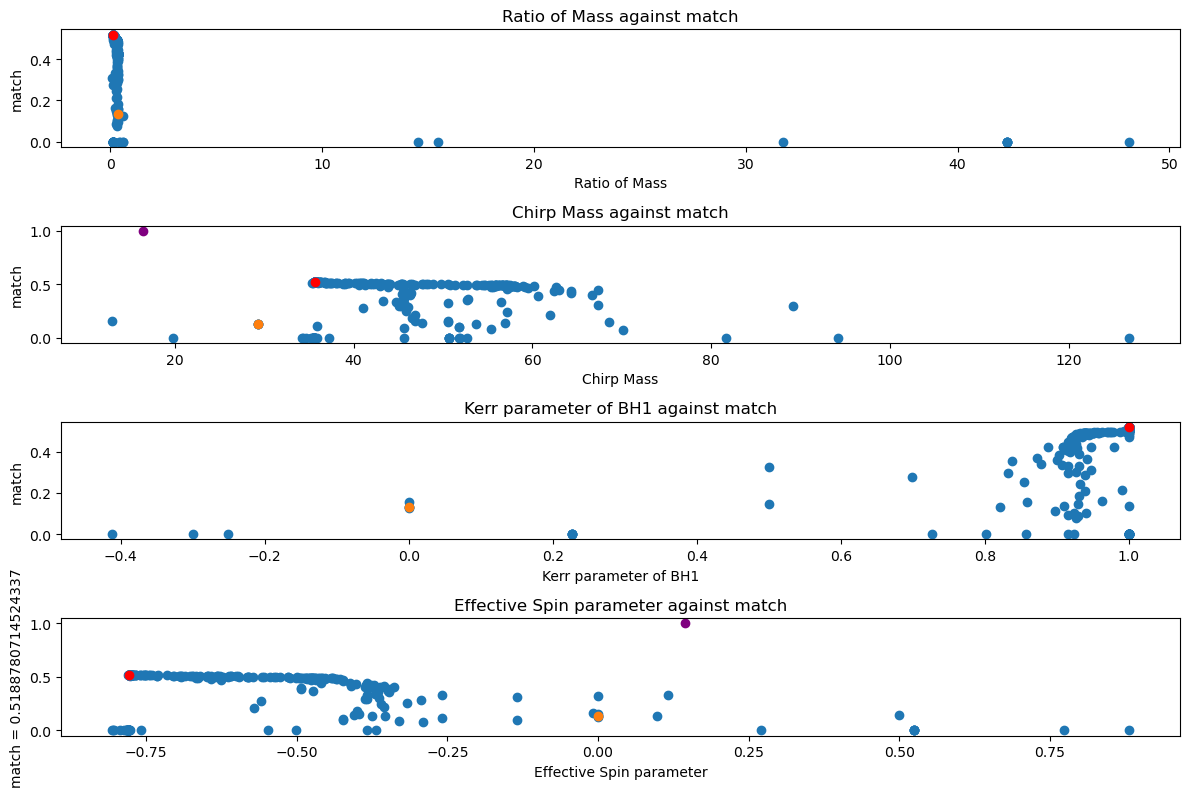

In [21]:
import matplotlib.pyplot as plt 

plot_match = []
plot_q_m = []
plot_chirp_mass = []
plot_a_1 = []
plot_eff_spin = []

for Data_List in Full_Data:
    plot_match.append(Data_List[0])
    plot_q_m.append(Data_List[1])
    plot_chirp_mass.append(Data_List[2]/lal.MSUN_SI)
    plot_a_1.append(Data_List[3])
    plot_eff_spin.append(Data_List[4])

Last_point=len(Full_Data)-1

# Plot the results
plt.figure(figsize=(12, 8))

# Plot the amplitude A(t)
plt.subplot(4, 1, 1)
plt.scatter(plot_q_m, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][1], Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][1], Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.title('Ratio of Mass against match')
plt.xlabel('Ratio of Mass')
plt.ylabel('match')

# Plot the phase phi(t)
plt.subplot(4, 1, 2)
plt.scatter(plot_chirp_mass, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][2]/lal.MSUN_SI, Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][2]/lal.MSUN_SI, Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.scatter(parameters_target.chirp_mass()/lal.MSUN_SI, 1, label = f'Target', color="purple")
plt.title('Chirp Mass against match')
plt.xlabel('Chirp Mass')
plt.ylabel('match')

# Plot the frequency f(t)
plt.subplot(4, 1, 3)
plt.scatter(plot_a_1, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][3], Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][3], Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.title('Kerr parameter of BH1 against match')
plt.xlabel('Kerr parameter of BH1')
plt.ylabel('match')

# Plot the frequency f(t)
plt.subplot(4, 1, 4)
plt.scatter(plot_eff_spin, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][4], Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][4], Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.scatter(parameters_target.eff_spin(), 1, label = f'Target', color="purple")
plt.title('Effective Spin parameter against match')
plt.xlabel('Effective Spin parameter')
plt.ylabel(f'match = {max_match}')

plt.tight_layout()
plt.show()

## Usamos ahora la masa total en vez del ratio entre las masas
(M_total, chirp_mass, a_1, eff_spin)

In [40]:
mass1_target = 25 * lal.MSUN_SI
mass2_target = 80 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0,0,0.95)
spin2_target = (0,0,0.95)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [41]:
def Measure(New_Data:list)->list:
    Full_Data.append(New_Data)
    return Full_Data


def opt_match_tests_2(prms:list, grad): # masses = [M, M_c, a_1, eff_spin]

    if (prms[0]**2-4*(prms[0]*prms[1]**5)**(1/3))<0:
        Full_Data = Measure([0, prms[0], prms[1], prms[2], prms[3]])
        return 0 # Penalizacion si la raiz es negativa (es una solución no válida)

    masses = M_c_and_M_total(prms[0], prms[1])

    if (masses[0]/masses[1])>200 or (masses[1]/masses[0])>200:
        Full_Data = Measure([0, prms[0], prms[1], prms[2], prms[3]])
        return 0

    spins = Eff_spin_and_spin1(masses[0], masses[1], prms[2], prms[3])

    if (abs(spins[0])-1)>0 or (abs(spins[1])-1)>0:
        Full_Data = Measure([0, prms[0], prms[1], prms[2], prms[3]])
        return 0 # Penalizacion si se saltan la restriccion del spin
    
    parameters = params(masses, (0, 0, spins[0]), (0, 0, spins[1]))

    hp, hc, time = simulationTD_IMRPhenomTPHM(parameters, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 
    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    Full_Data = Measure([match, prms[0], prms[1], prms[2], prms[3]])
    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

In [42]:
mass1_template = 60*lal.MSUN_SI
mass2_template = 20*lal.MSUN_SI
spin1_template = 0.5
spin2_template = 0.5

prms_initial_test=[(mass1_template+mass2_template), chirp_mass_function([mass1_template, mass2_template]),
                  spin1_template, eff_spin_function([mass1_template, mass2_template],[spin1_template, spin2_template])]

In [43]:
Full_Data=[]

opt_test = nlopt.opt(nlopt.LN_NELDERMEAD, 4) # De los que he probado AUGLAG es el que mejor va
opt_test.set_lower_bounds([0, 0, -1, -1]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors
opt_test.set_upper_bounds([float('inf'), float('inf'), 1, 1]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
opt_test.set_min_objective(opt_match_tests_2)
#opt_test.set_xtol_rel(1e-4)
opt_test.set_stopval(-1+1e-4)

prms_final = opt_test.optimize(prms_initial_test)
masses_final = M_c_and_M_total(prms_final[0], prms_final[1])
spins_final = Eff_spin_and_spin1(masses_final[0], masses_final[1], prms_final[2], prms_final[3])
max_match = -opt_test.last_optimum_value()


print(f"Optimum at masses {masses_final[0]/lal.MSUN_SI} and {masses_final[1]/lal.MSUN_SI} solar masses and spins {spins_final[0]} and {spins_final[1]}")
print(f"The target: {mass1_target/lal.MSUN_SI} and {mass2_target/lal.MSUN_SI} solar masses and spins {spin1_target} and {spin2_target}")
print(f"maximum value = {max_match}")
print(f"chirp mass: {prms_final[1]}, chirp mass target: {parameters_target.chirp_mass()}")
print(f"effective spin parameter: {prms_final[3]}, eff_spin_target: {parameters_target.eff_spin()}")
print(f"result code = {opt_test.last_optimize_result()}")


Optimum at masses 49.55676082991703 and 27.480090137091388 solar masses and spins 0.7994348037266079 and 0.19783454540247186
The target: 25.0 and 80.0 solar masses and spins (0, 0, 0.95) and (0, 0, 0.95)
maximum value = 0.8341194720179875
chirp mass: 6.333428104220698e+31, chirp mass target: 7.496974746741939e+31
effective spin parameter: 0.584835827811501, eff_spin_target: 0.95
result code = 4


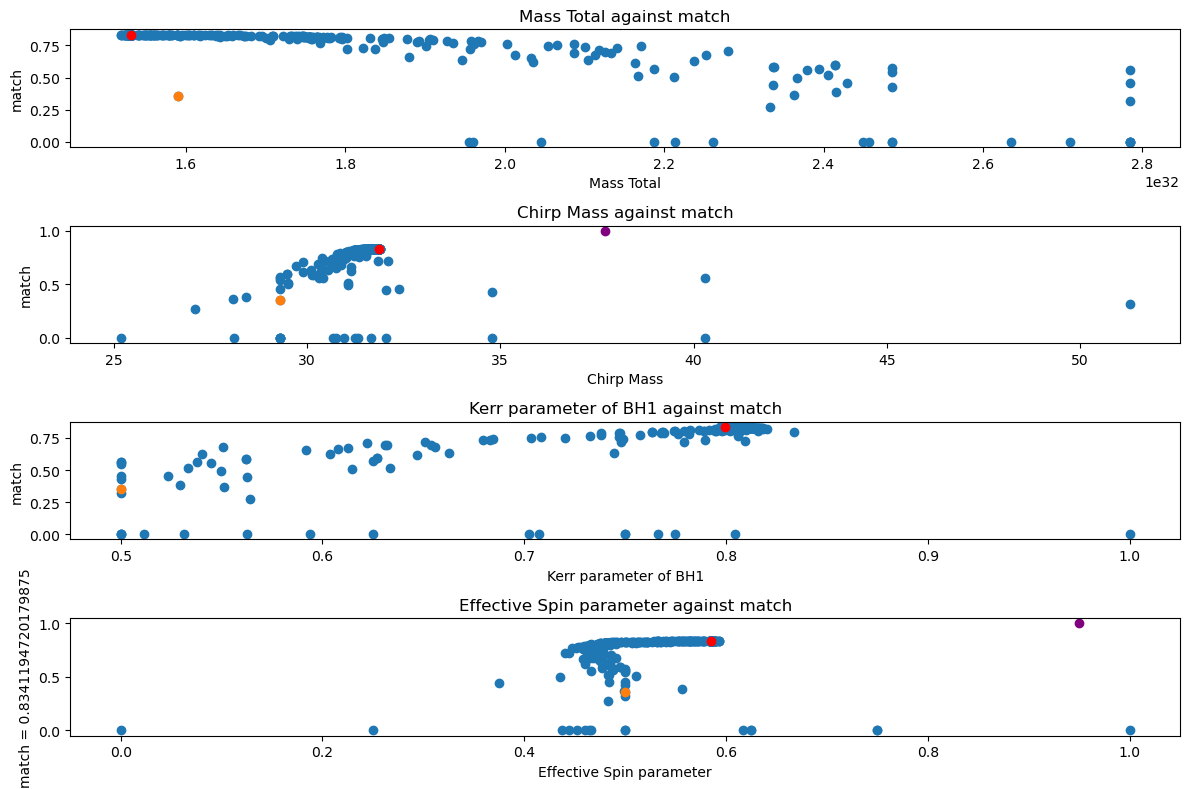

In [26]:
import matplotlib.pyplot as plt 

plot_match = []
plot_q_m = []
plot_chirp_mass = []
plot_a_1 = []
plot_eff_spin = []

for Data_List in Full_Data:
    plot_match.append(Data_List[0])
    plot_q_m.append(Data_List[1])
    plot_chirp_mass.append(Data_List[2]/lal.MSUN_SI)
    plot_a_1.append(Data_List[3])
    plot_eff_spin.append(Data_List[4])

Last_point=len(Full_Data)-1

# Plot the results
plt.figure(figsize=(12, 8))

# Plot the amplitude A(t)
plt.subplot(4, 1, 1)
plt.scatter(plot_q_m, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][1], Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][1], Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.title('Mass Total against match')
plt.xlabel('Mass Total')
plt.ylabel('match')

# Plot the phase phi(t)
plt.subplot(4, 1, 2)
plt.scatter(plot_chirp_mass, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][2]/lal.MSUN_SI, Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][2]/lal.MSUN_SI, Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.scatter(parameters_target.chirp_mass()/lal.MSUN_SI, 1, label = f'Target', color="purple")
plt.title('Chirp Mass against match')
plt.xlabel('Chirp Mass')
plt.ylabel('match')

# Plot the frequency f(t)
plt.subplot(4, 1, 3)
plt.scatter(plot_a_1, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][3], Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][3], Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.title('Kerr parameter of BH1 against match')
plt.xlabel('Kerr parameter of BH1')
plt.ylabel('match')

# Plot the frequency f(t)
plt.subplot(4, 1, 4)
plt.scatter(plot_eff_spin, plot_match, label = f'Travel')
plt.scatter(Full_Data[0][4], Full_Data[0][0], label = f'First Point')
plt.scatter(Full_Data[Last_point][4], Full_Data[Last_point][0], label = f'Last Point', color="red")
plt.scatter(parameters_target.eff_spin(), 1, label = f'Target', color="purple")
plt.title('Effective Spin parameter against match')
plt.xlabel('Effective Spin parameter')
plt.ylabel(f'match = {max_match}')

plt.tight_layout()
plt.show()